In [179]:
%load_ext autoreload
%autoreload 2

import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
#import pymaise 
print("hi")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
hi


In [180]:
from pyMAISE.datasets import load_anomaly
from pyMAISE.preprocessing import train_test_split, scale_data, one_hot_encode, SplitSequence
import pyMAISE as mai

In [181]:
global_settings = mai.init(
    problem_type=mai.ProblemType.CLASSIFICATION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only/ Delete line when run on GPU
   # verbosity = 3
)

In [182]:
# call handler
input_path = "/home/jacc/pyMAISE/pyMAISE/datasets/DTL.npy"
output_path = "/home/jacc/pyMAISE/pyMAISE/datasets/DTL_labels.npy"
#print(mai.__file__)
#False, False, False: WORKS       X.shape = (1077, 4500, 14), Y.shape = (1077, 1)  one hot
#False, True, False: WORKS       X.shape = (1077, 4500, 14), Y.shape = (1077, 1)
#False, False, True:  ?      X.shape = (1077, 4500, 14), Y.shape = (1077, 4500, 1)
#False, True, True:   ?      X.shape = (1077, 4500, 14), Y.shape = (1077, 4500, 1)
#True, False, True: WORKS        X.shape = (4846500, 14), Y.shape = (4846500, 1)
#True, True, True: WORKS         X.shape = (4846500, 14), Y.shape = (4846500, 1)
cond1 = True
cond2 = False
cond3 = True
inputs, outputs = load_anomaly([input_path, output_path], cond1, cond2, cond3)


In [183]:
inputs

<xarray.DataArray (timesteps: 4846500, features: 14)>
array([[-6.07100e+00,  5.55120e+00, -1.42220e+00, ..., -4.60370e-02,
         2.17170e+03,  1.27100e+00],
       [-4.85030e+00,  4.33040e+00, -2.64290e+00, ...,  1.50000e-02,
         2.17250e+03, -1.33776e+01],
       [-4.85030e+00,  1.88890e+00, -1.42220e+00, ...,  4.55190e-02,
         2.17320e+03, -8.49500e+00],
       ...,
       [-2.17470e+00, -7.57620e+00, -3.39550e+00, ..., -1.07070e-01,
         2.17220e+03,  1.19730e+01],
       [-4.61620e+00, -3.91400e+00, -5.83700e+00, ..., -1.68110e-01,
         2.17180e+03,  9.53200e+00],
       [-3.39550e+00, -6.35550e+00, -5.83700e+00, ..., -4.60370e-02,
         2.17150e+03,  9.53200e+00]], dtype=float32)
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) <U18 'A+IGBT-I: current' ... 'DV/DT'

In [184]:
outputs

<xarray.DataArray (timesteps: 4846500, features: 1)>
array([['Run'],
       ['Run'],
       ['Run'],
       ...,
       ['Fault'],
       ['Fault'],
       ['Fault']], dtype=object)
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) <U5 'Class'

In [185]:
outputs = one_hot_encode(outputs)
outputs

<xarray.DataArray (timesteps: 4846500, features: 2)>
array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) object 'Class_Fault' 'Class_Run'

In [186]:
data = xr.concat([inputs, outputs], dim="features")
data

<xarray.DataArray (timesteps: 4846500, features: 16)>
array([[ -6.0710001 ,   5.55119991,  -1.42219996, ...,   1.27100003,
          0.        ,   1.        ],
       [ -4.85029984,   4.33039999,  -2.64289999, ..., -13.37759972,
          0.        ,   1.        ],
       [ -4.85029984,   1.88890004,  -1.42219996, ...,  -8.49499989,
          0.        ,   1.        ],
       ...,
       [ -2.17470002,  -7.57620001,  -3.39549994, ...,  11.97299957,
          1.        ,   0.        ],
       [ -4.61619997,  -3.91400003,  -5.83699989, ...,   9.53199959,
          1.        ,   0.        ],
       [ -3.39549994,  -6.35550022,  -5.83699989, ...,   9.53199959,
          1.        ,   0.        ]])
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) object 'A+IGBT-I: current' ... 'Class_Run'

In [187]:
split_sequence = SplitSequence(
    10, 
    1, 
    0, 
    sequence_inputs=data.coords["features"].values[:-2], 
    sequence_outputs=data.coords["features"].values[-2:],
)
inputs, outputs = split_sequence.split(data)


In [188]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [189]:
xtrain, xtest, ytrain, ytest = train_test_split(inputs, outputs, test_size=0.3)
xtrain, xtest, x_scaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, y_scaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

In [194]:
xtrain = xtrain[:1000]
ytrain = ytrain[:1000]
xtest = xtest[:250]
ytest = ytest[:250]

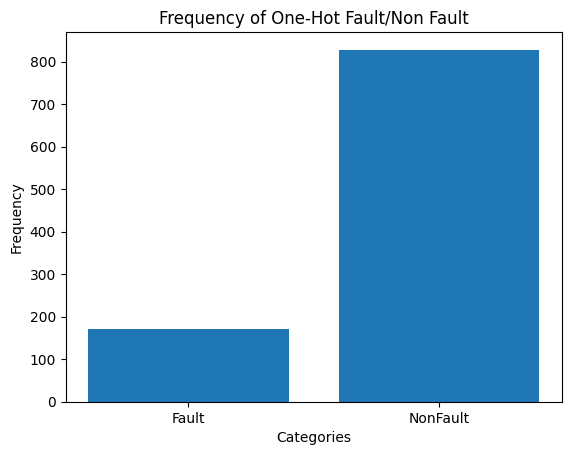

<xarray.DataArray (samples: 1000, features: 2)>
array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])
Coordinates:
  * samples   (samples) int64 2513113 2185081 4402688 ... 4090368 513492 3149174
  * features  (features) object 'Class_Fault' 'Class_Run'

In [195]:
ytrain

frequency = np.sum(ytrain, axis=0)

# Categories
categories = ['Fault', 'NonFault']

# Plot
plt.bar(categories, frequency)
plt.title('Frequency of One-Hot Fault/Non Fault')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='y')
plt.show()
ytrain

In [176]:
lstm_structure = {
    "LSTM_input": {
        "units": 50,
        "return_sequences": True,
        "input_shape": (xtrain.shape[1], xtrain.shape[2]),
    },
    "LSTM": {
        "num_layers": mai.Int(min_value=0, max_value=3),
        "units": 50,
        "return_sequences": True,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",
    },
#check activation to lstm to classification
    "LSTM_output": {
        "units": 50,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",

        
    },
    "Dense":{
         "num_layers": mai.Int(min_value=0, max_value=3),
         "units": mai.Int(min_value=25, max_value=250),
         "activation": "sigmoid", #do research on relu activation CHANGED
         "kernel_initializer": "normal",
         "sublayer": mai.Choice(["Dropout_hidden", "None"]),
         "Dropout_hidden": {
         "rate": mai.Float(min_value=0.4, max_value=0.6),}
    },
    "Dense_output": {
        "units": ytrain.shape[1],
        "activation": "softmax",
    },
}
#change nodes in each layer, not in the output
fitting = {
    "batch_size":128,# mai.Choice([16, 32, 64]), changed dfrom 128
    "epochs": 5,
    "validation_split":0.15,
    "callbacks": [
        ReduceLROnPlateau(
            monitor='accuracy',
            factor=0.8,
            patience=2,
            min_lr=0,
            verbose=1,
        ),
        EarlyStopping(
            monitor="accuracy",
            patience=3,
        )
    ]
}
adam = {
    "learning_rate": mai.Float(min_value=0.00001, max_value=0.001),
   # "clipnorm": mai.Float(min_value=0.8, max_value=1.2),
  #  "clipvalue": mai.Float(min_value=0.3, max_value=0.7),
}
compiling = {
    "loss": "binary_crossentropy",#figure out accuracy on keras keras lstm on classification
    "metrics": ["accuracy"],
}

model_settings = {
    "models": ["LSTM"],
    "LSTM": {
        "structural_params": lstm_structure,
        "optimizer": "Adam",
        "Adam": adam,
        "compile_params": compiling,
        "fitting_params": fitting,
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

In [177]:
lstm_structure

{'LSTM_input': {'units': 50,
  'return_sequences': True,
  'input_shape': (10, 14)},
 'LSTM': {'num_layers': <pyMAISE.utils.hyperparameters.Int at 0x79b096b19010>,
  'units': 50,
  'return_sequences': True,
  'activation': 'tanh',
  'recurrent_activation': 'sigmoid'},
 'LSTM_output': {'units': 50,
  'activation': 'tanh',
  'recurrent_activation': 'sigmoid'},
 'Dense': {'num_layers': <pyMAISE.utils.hyperparameters.Int at 0x79b088673250>,
  'units': <pyMAISE.utils.hyperparameters.Int at 0x79b0bcce7e10>,
  'activation': 'sigmoid',
  'kernel_initializer': 'normal',
  'sublayer': <pyMAISE.utils.hyperparameters.Choice at 0x79b0bcce57d0>,
  'Dropout_hidden': {'rate': <pyMAISE.utils.hyperparameters.Float at 0x79b082588dd0>}},
 'Dense_output': {'units': 2, 'activation': 'softmax'}}

In [178]:

start = time.time()

bayesian_search_configs = tuner.nn_bayesian_search(
    objective="accuracy_score",
    max_trials=5,
    cv=5,
)

print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
3                 |3                 |LSTM_num_layers
1                 |1                 |Dense_num_layers
0.00083211        |0.00083211        |Adam_learning_rate



KeyboardInterrupt: 

In [ ]:
xtrain

In [ ]:
ytrain.shape

In [ ]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 10}},
    },
  #  y_scaler=y_scaler,
)

In [ ]:
postprocessor.metrics()

In [ ]:
for model in [ "LSTM"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

In [ ]:
idx = postprocessor._get_idx()
idx

In [ ]:
#postprocessor._models()
yhat_test = postprocessor._models["Test Yhat"][idx]

In [ ]:
postprocessor.get_model()

In [ ]:
 yhat_test

In [ ]:
#postprocessor.confusion_matrix(model_type = "LSTM")
yhat_train = postprocessor._models["Train Yhat"][idx]
yhat_test = postprocessor._models["Test Yhat"][idx]


In [ ]:
ytrain = postprocessor._ytrain.values
ytest = postprocessor._ytest.values

In [ ]:
ax = plt.gca()

In [ ]:
from sklearn.preprocessing import StandardScaler

ytrain = y_scaler.inverse_transform(
                ytrain.reshape(-1, ytrain.shape[-1])
            )
ytest = y_scaler.inverse_transform(ytest.reshape(-1, ytest.shape[-1]))

In [ ]:
ytrain = np.round(ytrain).astype(int)
ytrain.shape

In [ ]:
yhat_train.shape

In [ ]:
yhat_train_single = np.argmax(yhat_train, axis=1)

In [ ]:
ytrain_single = np.argmax(ytrain, axis=1)

In [ ]:
yhat_train_single.shape

In [ ]:
ytrain_single.shape

In [ ]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
)
from sklearn.metrics import confusion_matrix

train_cm = confusion_matrix(ytrain_single , yhat_train_single)
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm)


In [ ]:
train_disp.plot()

In [ ]:
ytest = np.round(ytest).astype(int)
ytest.shape

In [ ]:
yhat_test.shape

In [ ]:
yhat_test_single = np.argmax(yhat_test, axis=1)

In [ ]:
ytest_single = np.argmax(ytest, axis=1)

In [ ]:
yhat_test_single.shape

In [ ]:
ytest_single.shape

In [ ]:
test_cm = confusion_matrix(ytest_single, yhat_test_single)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm)



In [ ]:
test_disp.plot()